<a href="https://colab.research.google.com/github/7angel4/weighted-jk/blob/main/JKGCN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

###Part 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [1]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Part 1. Oversmoothing

This part aims to investigate **oversmoothing**: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

### A. Model Implementation and Training

#### a. Import required packages

Please run the below code block to import the required python packages.

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [4]:
dataset_names = ['Cora', 'CiteSeer', 'PubMed']
all_datasets = { name: datasets.Planetoid(
                root="./",
                name=name,
                split="public",
                transform=torch_geometric.transforms.GCNNorm()
                ) for name in dataset_names
              }
# Use Cora as example
dataset = all_datasets['Cora']
print(dataset.data)

Processing...
Done!
Processing...
Done!
Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


`dataset.data.x` : input node features

`dataset.data.edge_index` : A sparce adjacent matrix with the size of *2 x n_edge*.

`dataset.data.y` : target labels

`dataset.data.train_mask` : boolean mask indicating whether an index belongs to training data

`dataset.data.val_mask` : boolean mask indicating whether an index belongs to validation data

`dataset.data.test_mask` : boolean mask indicating whether an index belongs to test data

#### c. Setup graph convolutional networks for node classification
Here we define a GCN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*.

- Note that the `forward` function should return a Tensor object: **logits**, and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [53]:
class GCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int,
                 n_classes: int, n_layers: int,
                 dropout_ratio: float = 0.3):
        """
        Args:
            input_dim: input feature dimension
            hid_dim: hidden feature dimension
            n_classes: number of target classes
            n_layers: number of layers
            dropout_ratio: dropout_ratio
        """
        super(GCN, self).__init__()
        assert n_layers > 1
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        layers = [GCNConv(input_dim, hid_dim)]
        layers += [GCNConv(hid_dim, hid_dim) for _ in range(1, n_layers)]
        self.layers = nn.ModuleList(layers)
        self.mlp = nn.Linear(hid_dim, n_classes) # final MLP for generating logits

        self.param_init()

    def forward(self, X, A) -> torch.Tensor:
        X = self.generate_node_embeddings(X, A)
        return self.mlp(X)

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        """ Generate node embeddings without applying the MLP. """
        for l in self.layers[:-1]: # message-passing through all layers
            X = l(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)
        return self.layers[-1](X, A)  # raw GNN output without applying MLP

    def param_init(self):
        # initialise MLP parameters
        nn.init.xavier_uniform_(self.mlp.weight)
        nn.init.zeros_(self.mlp.bias)
        for conv in self.layers:
            # initialise weight in each layer's Linear object
            nn.init.xavier_uniform_(conv.lin.weight)
            nn.init.zeros_(conv.bias)

In [61]:
class SkipGCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int,
                 n_classes: int, n_layers: int,
                 dropout_ratio: float = 0.3):
        """
        Args:
          input_dim: input feature dimension
          hid_dim: hidden feature dimension
          n_classes: number of target classes
          n_layers: number of layers
          dropout_ratio: dropout ratio
        """
        super(SkipGCN, self).__init__()
        assert n_layers > 1
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        layers = [GCNConv(input_dim, hid_dim)]
        layers += [GCNConv(hid_dim, hid_dim) for _ in range(1, n_layers)]
        self.layers = nn.ModuleList(layers)
        self.mlp = nn.Linear(hid_dim, n_classes)

        self.param_init()

    def forward(self, X, A) -> torch.Tensor:
        X = self.generate_node_embeddings(X, A)
        return self.mlp(X)


    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        """Generate node embeddings without applying the MLP."""
        X = self.layers[0](X, A)
        X = F.relu(X)
        X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        for l in self.layers[1:-1]: # message-passing through all layers
            residual = X  # previous layer's representation
            X = l(X, A)
            X = F.relu(X)
            dropout_mask = F.dropout(
                torch.ones_like(X),
                p=self.dropout_ratio,
                training=self.training)
            X = X * dropout_mask
            residual = residual * dropout_mask
            X = X + residual  # add skip connection

        return self.layers[-1](X, A)

    def param_init(self):
        nn.init.xavier_uniform_(self.mlp.weight)
        nn.init.zeros_(self.mlp.bias)
        for conv in self.layers:
            nn.init.xavier_uniform_(conv.lin.weight)
            nn.init.zeros_(conv.bias)

In [62]:
class JumpKnowGCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hid_dim: int,
        n_classes: int,
        n_layers: int,
        dropout_ratio: float = 0.3):
        """
        Args:
            input_dim: input feature dimension
            hid_dim: hidden feature dimension
            n_classes: number of target classes
            n_layers: number of layers
            dropout_ratio: dropout ratio
        """
        super(JumpKnowGCN, self).__init__()
        assert n_layers > 1
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        layers = [GCNConv(input_dim, hid_dim)]
        layers += [GCNConv(hid_dim, hid_dim) for _ in range(1, n_layers)]
        self.layers = nn.ModuleList(layers)
        self.mlp = nn.Linear(hid_dim, n_classes)

        self.param_init()


    def _layer_outputs(self, X, A) -> torch.Tensor:
        """ Outputs of all layers
            (no activation & dropout applied to the final layer -
            i.e. last element is just logits)
        """
        outputs = []
        for l in self.layers[:-1]:
            X = l(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)
            outputs.append(X)

        outputs.append(self.layers[-1](X, A))
        return outputs


    def forward(self, X, A) -> torch.Tensor:
      return self._layer_outputs(X, A)[-1]

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        outputs = self._layer_outputs(X, A)[:-1]
        return torch.max(torch.stack(outputs), 0)[0]  # max pooling

    def param_init(self):
        for conv in self.layers:
            nn.init.xavier_uniform_(conv.lin.weight)
            nn.init.zeros_(conv.bias)

In [63]:
class WeightedSkipGCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int,
                 n_classes: int, n_layers: int,
                 dropout_ratio: float = 0.3,
                 init_res_weight: float = 0.3):
        """
        Args:
          input_dim: input feature dimension
          hid_dim: hidden feature dimension
          n_classes: number of target classes
          n_layers: number of layers
          dropout_ratio: dropout ratio
        """
        super(WeightedSkipGCN, self).__init__()
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
        self.res_weight = nn.Parameter(torch.tensor(init_res_weight,
                                                    dtype=torch.float32))

        layers = [GCNConv(input_dim, hid_dim)]
        layers += [GCNConv(hid_dim, hid_dim) for _ in range(1, n_layers)]
        self.layers = nn.ModuleList(layers)
        self.mlp = nn.Linear(hid_dim, n_classes)
        self.param_init()

    def forward(self, X, A) -> torch.Tensor:
        X = self.generate_node_embeddings(X, A)
        return self.mlp(X)  # MLP maps to logits


    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        """Generate node embeddings without applying the MLP."""
        # First GCNConv layer
        X = self.layers[0](X, A)
        X = F.relu(X)
        X = F.dropout(X, p=self.dropout_ratio, training=self.training)

        # Intermediate GCNConv layers with skip connections
        for l in self.layers[1:-1]:
            residual = X  # previous layer's representation
            X = l(X, A)
            X = F.relu(X)
            dropout_mask = F.dropout(
                torch.ones_like(X),
                p=self.dropout_ratio,
                training=self.training)
            X = X * dropout_mask
            residual = residual * dropout_mask
            X = self.res_weight * X + residual  # Add skip connection

        # Final GCNConv layer outputs raw embeddings
        return self.layers[-1](X, A)

    def param_init(self):
        nn.init.xavier_uniform_(self.mlp.weight)
        nn.init.zeros_(self.mlp.bias)
        for conv in self.layers:
            nn.init.xavier_uniform_(conv.lin.weight)
            nn.init.zeros_(conv.bias)

#### c. Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

In [9]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
import typing

# Moved this to before definition of train()
def evaluate(model, data, mask):
    """
    Evaluates model and returns its validation accuracy on given mask.
    """
    model.eval()  # to evaluation mode
    with torch.no_grad():  # disable gradient computation during evaluation
        # forward pass
        out = model(data.x, data.edge_index)
        # predict the class with max score
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        accuracy = correct.sum() / mask.sum()
    return accuracy

In [11]:
MODELS = ['GCN', 'SkipGCN', 'JumpKnowGCN', 'WeightedSkipGCN']

In [83]:
# helper functions for data and model initialization
# extracted from the original train()
def load_data(device, dataset_name):
    dataset = all_datasets[dataset_name]
    data = dataset.data
    data = data.to(device)
    return data

def set_model(params, device):
    model_name = params['model_name']
    model_params = [params["input_dim"], params["hid_dim"],
                    params["n_classes"], params["n_layers"]]
    if model_name in MODELS:
        model = globals()[model_name](*model_params)
        return model
    else:
        raise NotImplementedError

In [90]:
def train(params: typing.Dict,
          report_per_period=100) -> torch.nn.Module:
    """
    Trains a node classification model and
    returns the trained model object.
    """
    # set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # load dataset
    data = load_data(device, params['dataset'])

    # Update parameters
    params["n_classes"] = dataset.num_classes  # number of target classes
    params["input_dim"] = dataset.num_features  # size of input features

    # Set a model
    model = set_model(params, device)

    # initialize model, optimizer, loss function
    model.param_init()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = torch.nn.CrossEntropyLoss()
    n_epochs = params['epochs']

    # params for early stopping
    best_val_acc = 0  # best validation accuracy
    epochs_dec_acc = 0  # number of consecutive epochs with decreasing validation accuracy
    # k: stop if epochs_dec_acc >= patience
    patience = params['max_patience']

    # train with backpropagation
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index) # forward pass
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # backward pass
        optimizer.step()

        # evaluate on validation set
        val_acc = evaluate(model, data, data.val_mask)

        # early stopping
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            epochs_dec_acc = 0
        else:
            epochs_dec_acc += 1

        # patience exceeded -> stop training
        if epochs_dec_acc >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # print training progress
        if epoch % report_per_period == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}...")
            print(f"Loss: {loss};")
            print(f"Validation Accuracy: {val_acc}\n")

    return model

#### d. Set training hyper-parameters

In [91]:
default_training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "WeightedSkipGCN",
    "dataset": "Cora"
}


#### e. Train 4 GCN models with 0, 1, 3 and 10 layers.

In [92]:
torch.manual_seed(77888) # set seed

In [93]:
# n_layers_model = dict()
# for n_layers in [2,3,10,20,200]:
#     training_params["n_layers"] = n_layers
#     n_layers_model[n_layers] = train(training_params)

In [94]:
def train_model(model_name,
                params=default_training_params,
                report_per_period=100):
    n_layers_model = dict()
    num_layers = [2,3,10,20,200]
    params['model_name'] = model_name
    for n in [2,3,10,20,200]:
        params['n_layers'] = n
        n_layers_model[n] = train(params, report_per_period)

    return n_layers_model

In [ ]:
trained_models = dict()
for model_name in MODELS:
    print(f"Training {model_name} ...")
    trained_models[model_name] = train_model(model_name)
    print()

Training GCN ...
Epoch 1/100...
Loss: 1.9509397745132446;
Validation Accuracy: 0.40400001406669617



/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 15
Epoch 1/100...
Loss: 1.9389979839324951;
Validation Accuracy: 0.38600000739097595

Early stopping at epoch 19
Epoch 1/100...
Loss: 1.9464671611785889;
Validation Accuracy: 0.057999998331069946

Early stopping at epoch 25
Epoch 1/100...
Loss: 1.9458736181259155;
Validation Accuracy: 0.11400000005960464

Early stopping at epoch 11
Epoch 1/100...
Loss: 1.9459097385406494;
Validation Accuracy: 0.12200000137090683

Early stopping at epoch 9

Training SkipGCN ...
Epoch 1/100...
Loss: 1.933319091796875;
Validation Accuracy: 0.47999998927116394

Early stopping at epoch 14
Epoch 1/100...
Loss: 1.9556790590286255;
Validation Accuracy: 0.5400000214576721

Early stopping at epoch 10
Epoch 1/100...
Loss: 3.3494088649749756;
Validation Accuracy: 0.30000001192092896

Early stopping at epoch 9
Epoch 1/100...
Loss: 176.5985870361328;
Validation Accuracy: 0.057999998331069946

Early stopping at epoch 9
Epoch 1/100...
Loss: nan;
Validation Accuracy: 0.12200000137090683



KeyboardInterrupt: 

### B. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

Please use the **validation dataset** for the visualisation.

#### a. Import required packages

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

#### b. Task 3) Implement a function for demensionality reduction

- The `dimension_reduction` function will take a model object and data, perform T-SNE, and return a *DataFrame* that contains reduced variables and labels for each data point.
- Please reduce the dimension to 2d.
- Use validation data for the visualisation

** You may refer this address below using T-SNE:
[Link to sklearn T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Args:
    - model: model object for generating features
    Returns:
    - pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2',
                    and 'labels' as a column
     """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = load_data(device)

    model.eval()
    x = data.x.to(device)  # node features
    edge_index = data.edge_index.to(device)  # graph structure

    # get node embeddings
    with torch.no_grad():  # disable gradient calculation
        node_embeddings = model.generate_node_embeddings(x, edge_index) # (X, A)

    # dim-reduction of node embeddings with T-SNE (to 2D)
    tsne = TSNE(n_components=2, random_state=123)
    # need to copy Tensor to host memory first with .cpu().numpy()
    reduced_embeddings = tsne.fit_transform(node_embeddings.cpu().numpy())

    # format result df
    reduced_df = pd.DataFrame(reduced_embeddings,
                              columns=['dimension 1', 'dimension 2'])
    reduced_df['labels'] = data.y.cpu().numpy()  # target labels

    return reduced_df


#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

#### d. Task 4) Implement a function for the visualisation and draw scatter plots

- Using `matplotlib` package is recommended, but you may use any other tool.
- Please refer to this page if you are not familar with the visualisation tool: [Link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

In [ ]:
def visualise_one(model_name, df) -> None:
    """Visualize node embeddings as a scatter plot for one model."""

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'],
                         cmap='tab10', s=10)
    plt.colorbar(scatter, ax=ax, label='class')  # color bar for classes

    ax.set_title("Visualization of node embeddings (dim-reduced by T-SNE)",
                 fontsize=16)
    ax.set_xlabel("dimension 1", fontsize=14)
    ax.set_ylabel("dimension 2", fontsize=14)

    # show the plot
    plt.show()
    fig.savefig(f'P4_visualization_{model_name}.jpg', bbox_inches='tight')

In [ ]:
def visualise(feature_dict: typing.Dict) -> None:
    """Visualize node embeddings as a scatter plot
       for all models in `feature_dict`."""
    for model in feature_dict.items():
        visualise_one(*model)

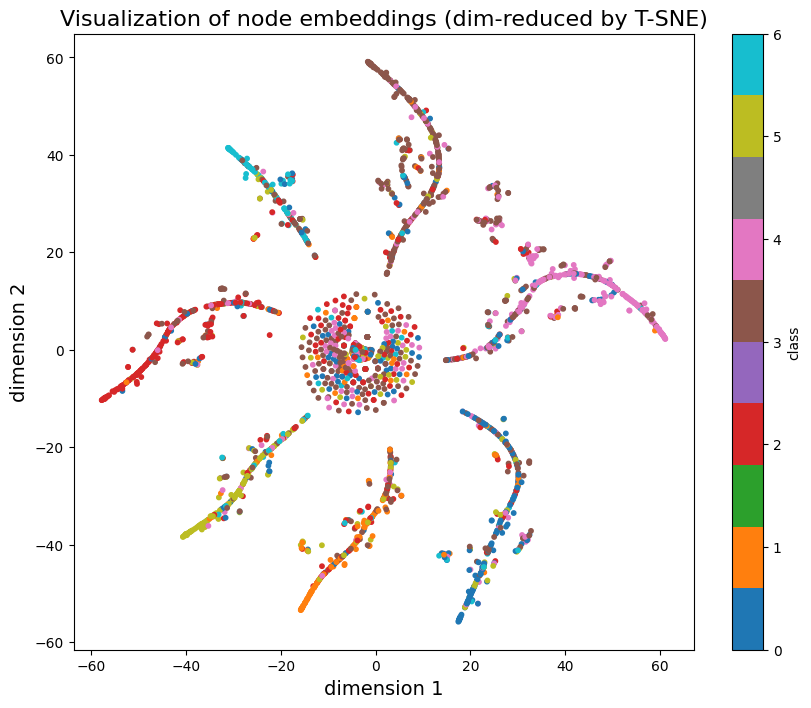

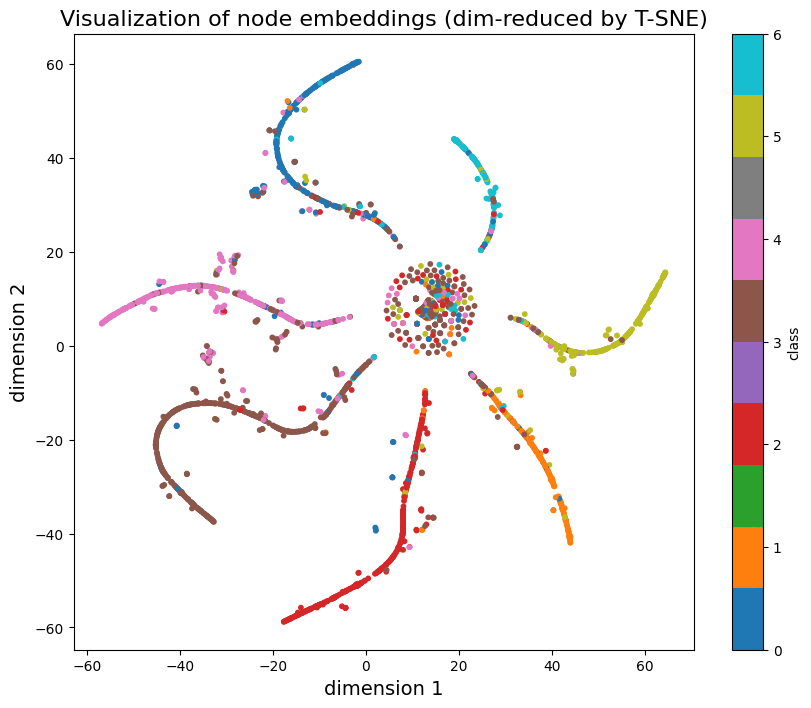

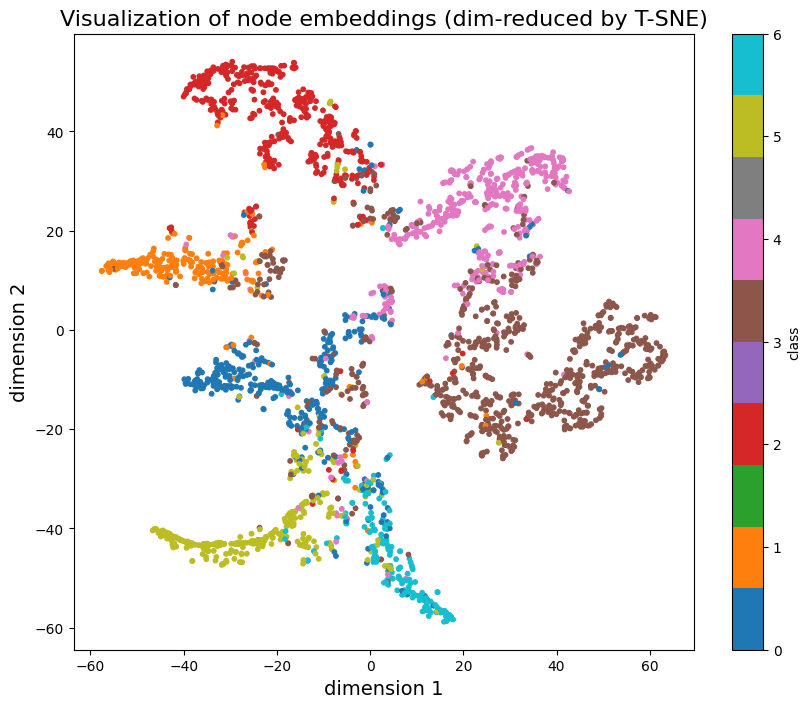

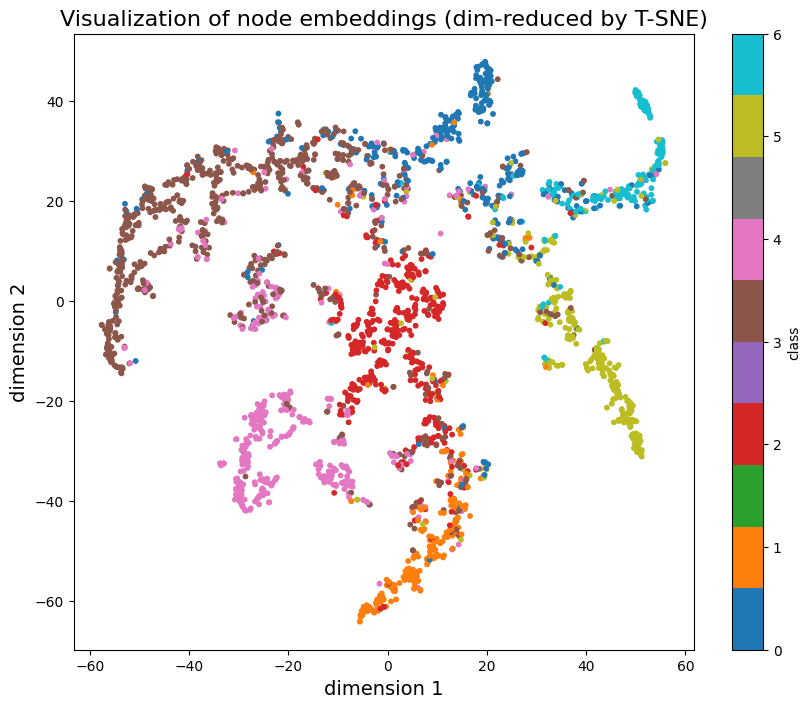

In [ ]:
visualise(feature_dict)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits**, and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

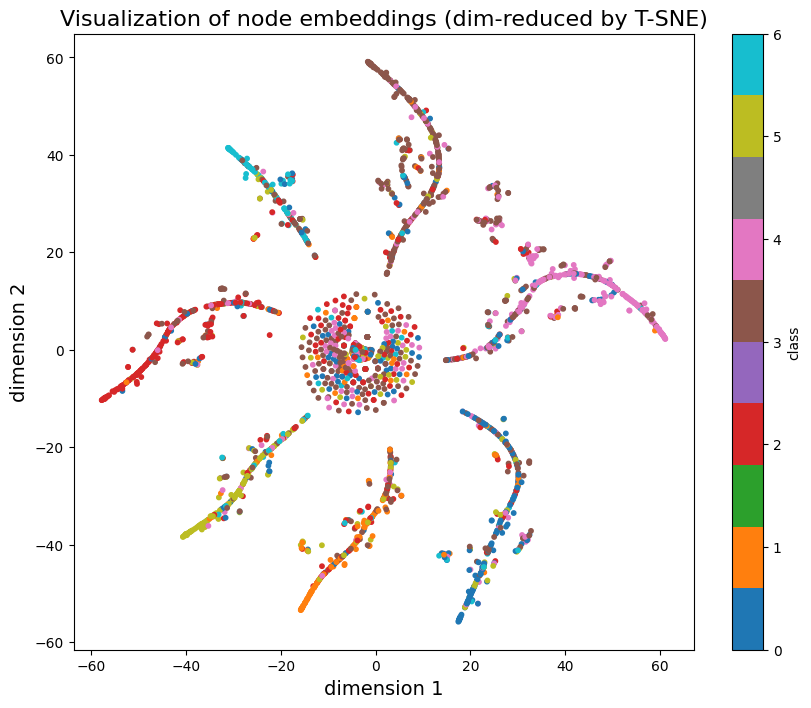

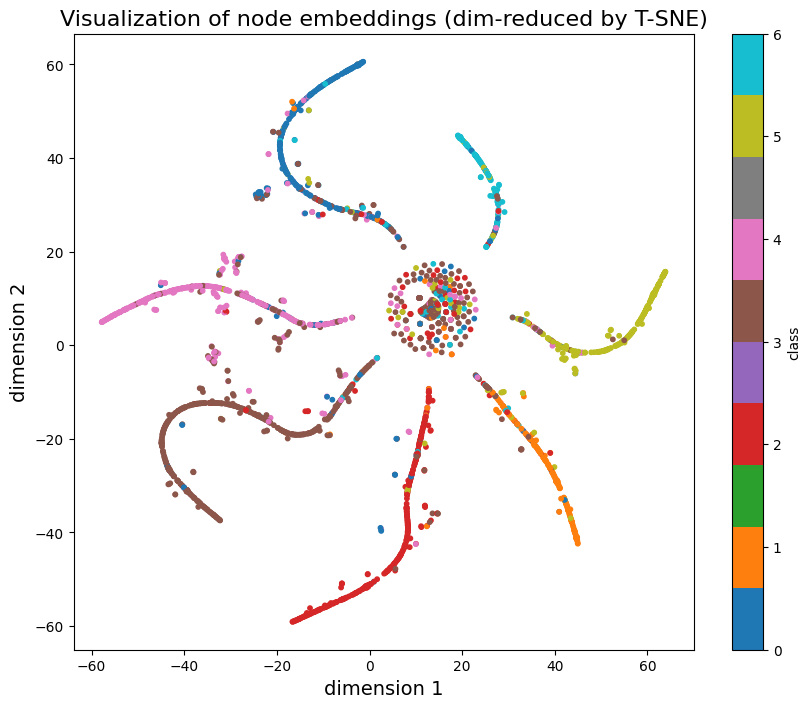

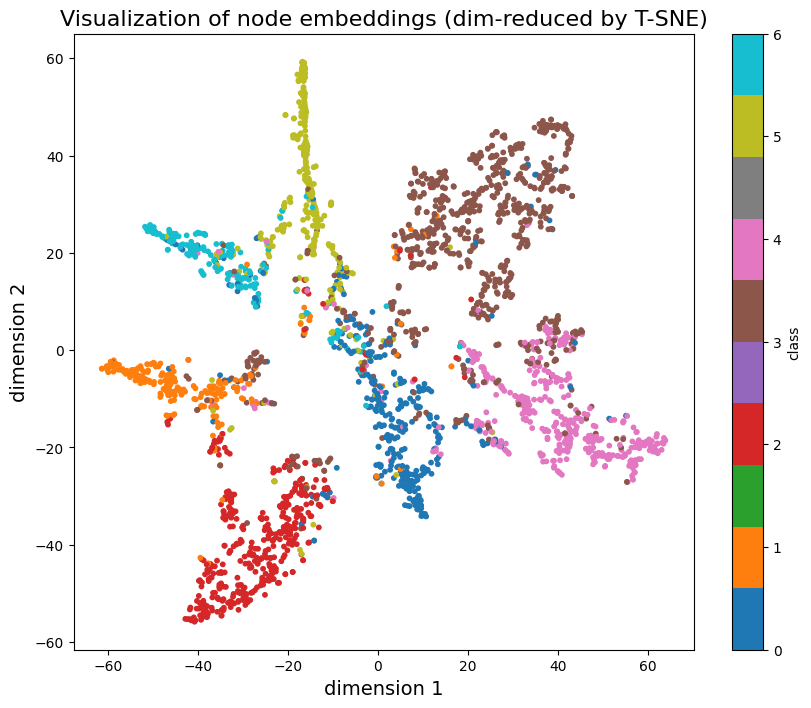

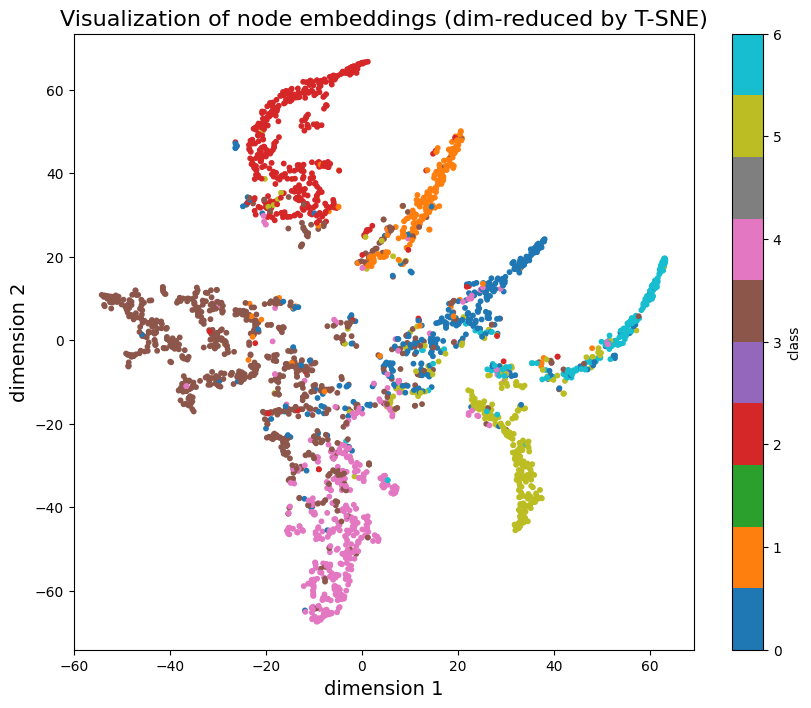

In [ ]:
visualise(feature_dict)

## Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
# added prefix 'jk_' to distinguish model names in output visualization files
feature_dict = {
    "jk_0_layer": dimension_reduction(model_0_layer),
    "jk_1_layer": dimension_reduction(model_1_layer),
    "jk_3_layer": dimension_reduction(model_3_layer),
    "jk_10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

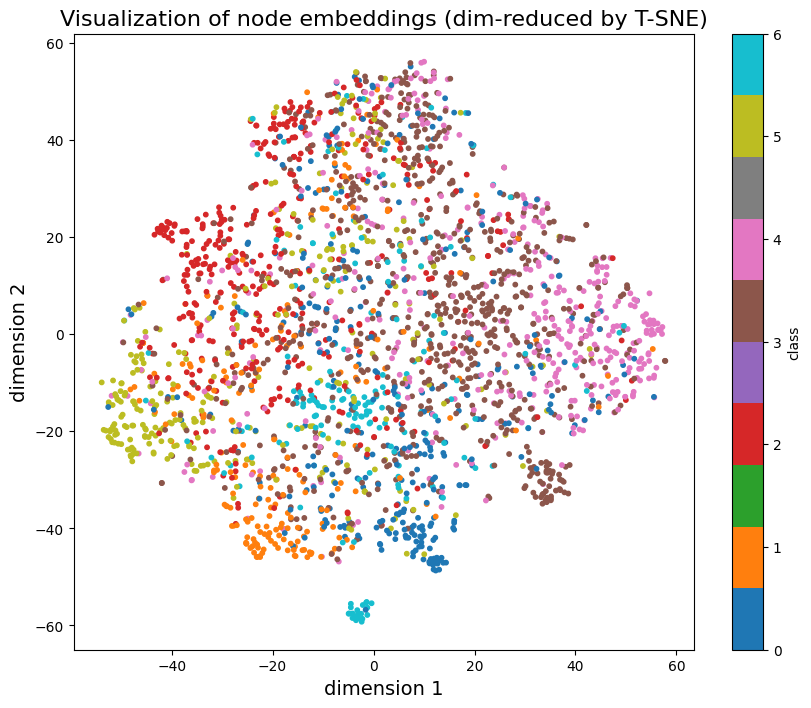

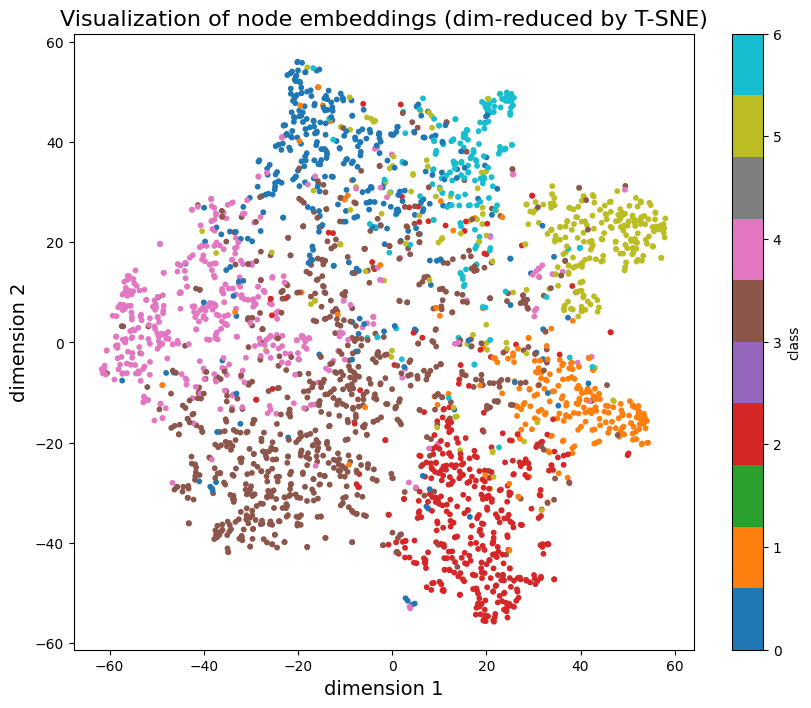

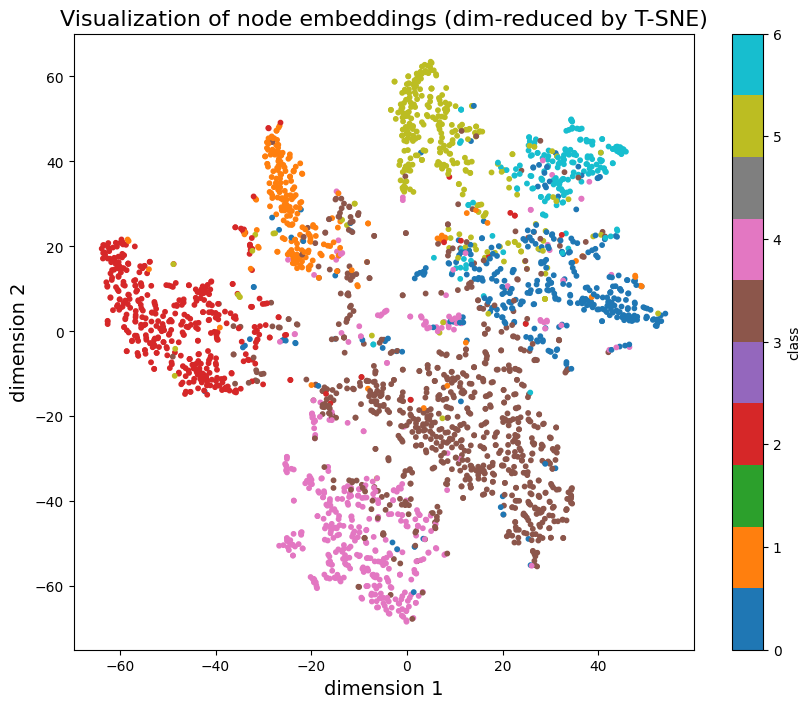

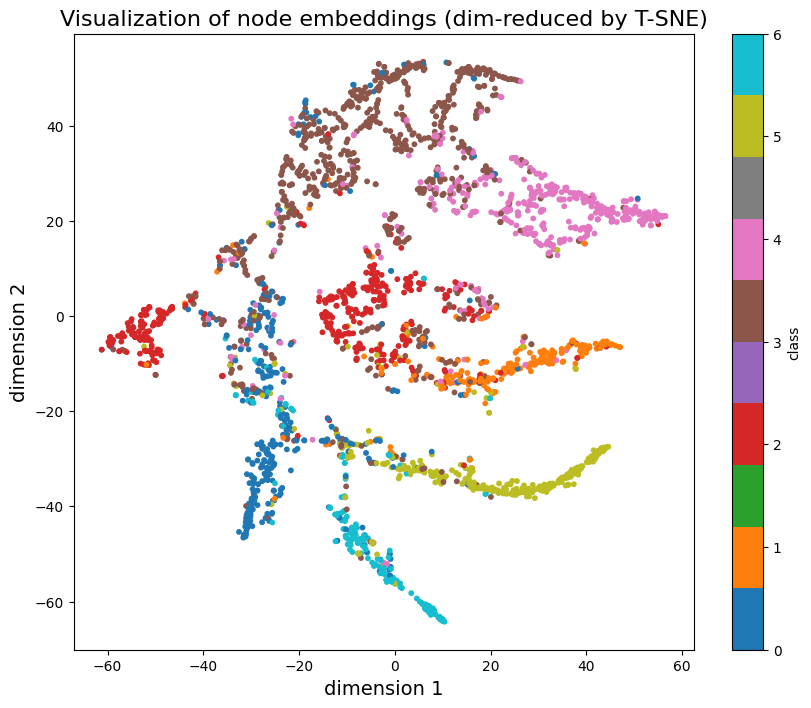

In [ ]:
visualise(feature_dict)

# MY NEW MODEL

In [ ]:
# added prefix 'ws_' to distinguish model names in output visualization files
feature_dict = {
    "ws_0_layer": dimension_reduction(model_0_layer),
    "ws_1_layer": dimension_reduction(model_1_layer),
    "ws_3_layer": dimension_reduction(model_3_layer),
    "ws_10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

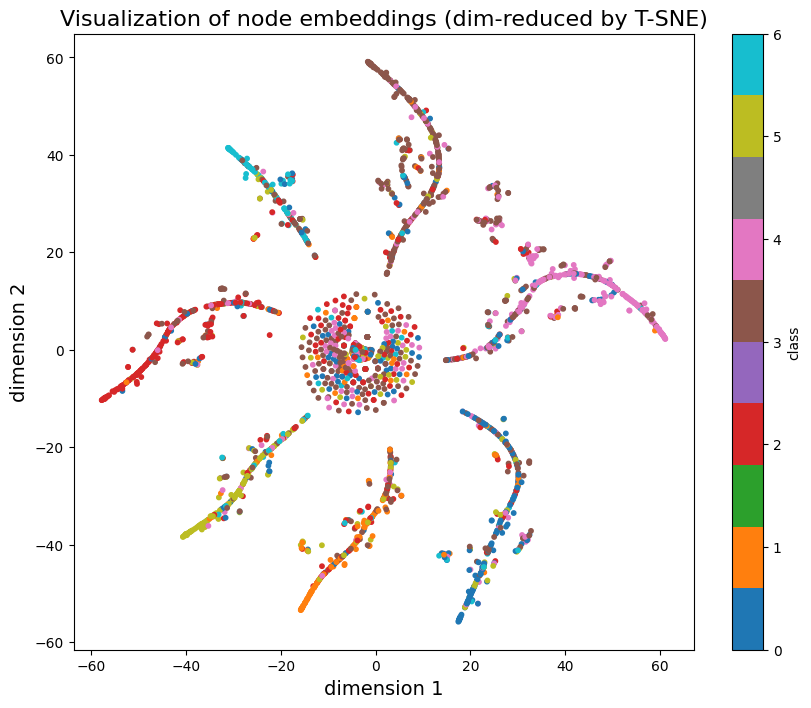

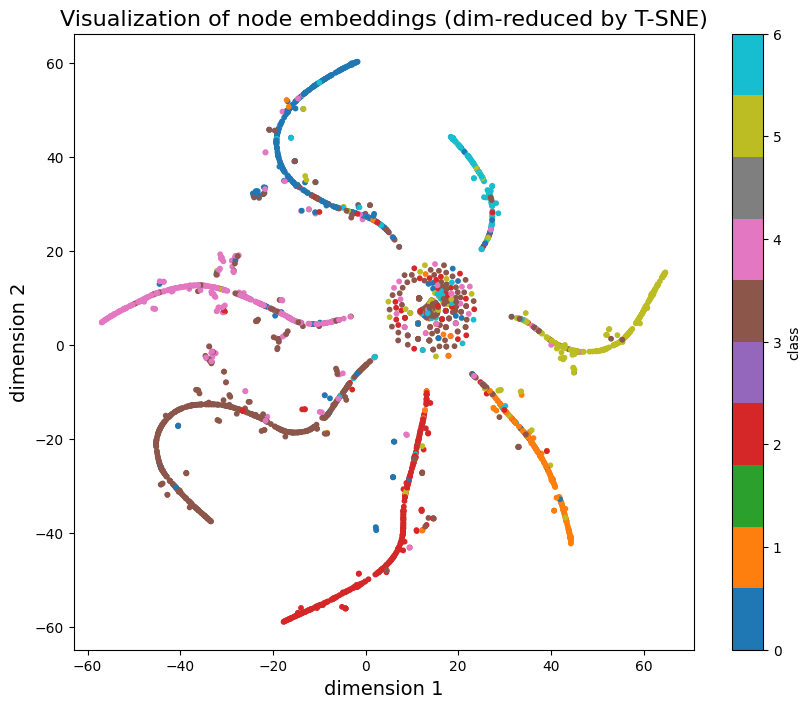

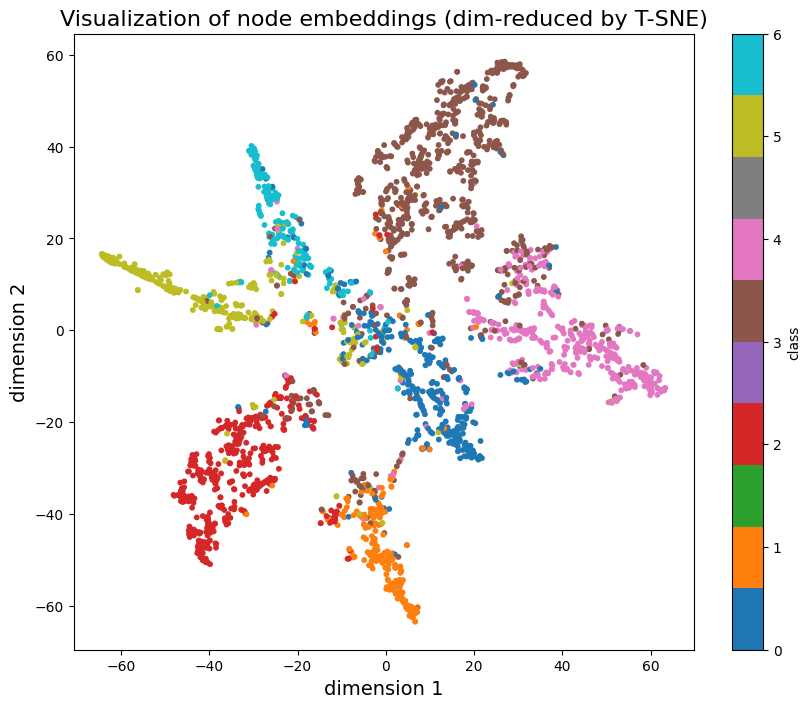

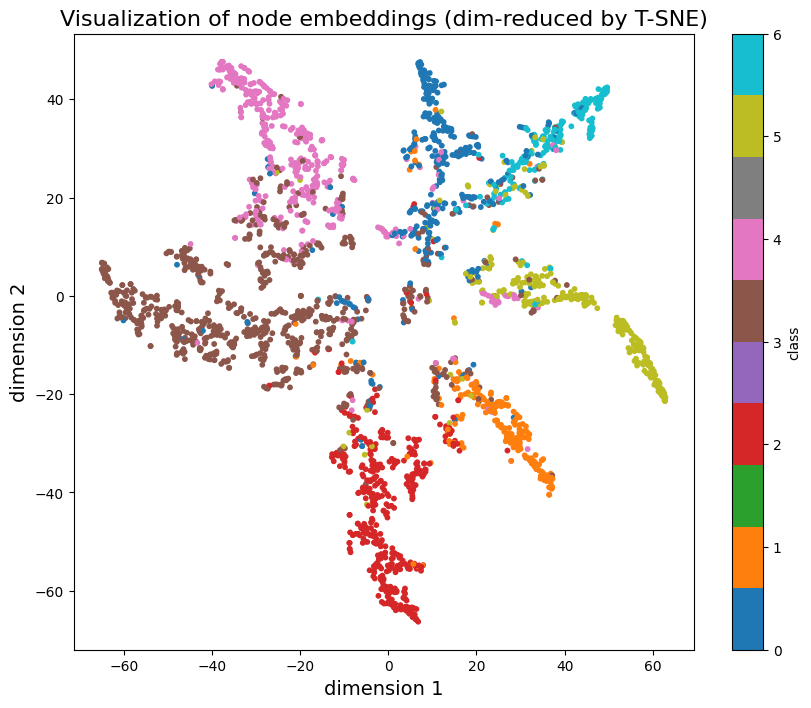

In [ ]:
visualise(feature_dict)